In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Dimensionality reduction for classification tasks

In [4]:
mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]
y=mnist[:,0]
print ("dimension de las imagenes y las clases", X.shape, y.shape)

dimension de las imagenes y las clases (1500, 784) (1500,)


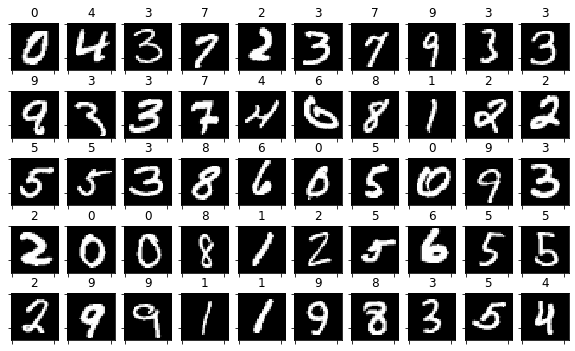

In [5]:
perm = np.random.permutation(range(X.shape[0]))[0:50]
random_imgs   = X[perm]
random_labels = y[perm] 
fig = plt.figure(figsize=(10,6))
for i in range(random_imgs.shape[0]):
    ax=fig.add_subplot(5,10,i+1)
    plt.imshow(random_imgs[i].reshape(28,28), interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_title(int(random_labels[i]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

## Simple classification by linearization of the image

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

print (np.mean(cross_val_score(GaussianNB(), X,y, cv=5 )))

0.5953333333333334


## Principal Component Analysis

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=60)
Xp = pca.fit_transform(X)


### obtain principal components

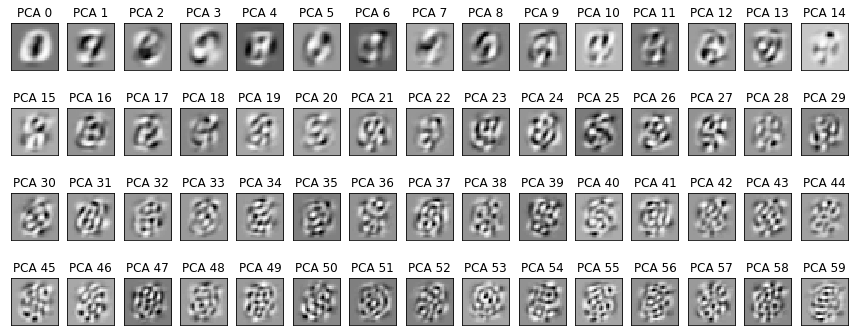

In [21]:
cols=20
plt.figure(figsize=(15,6))
for i in range(len(pca.components_)):
    plt.subplot(np.ceil(len(pca.components_)/15.),15,i+1)
    plt.imshow((pca.components_[i].reshape(28,28)), cmap = plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])
    plt.title("PCA %d"%i)

observe that the components have positive and negative values (showing only the first 10 components)

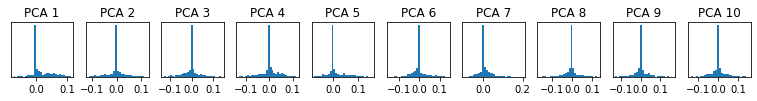

In [22]:
cols=20
plt.figure(figsize=(20,1))
for i in range(10):
    plt.subplot(1,15,i+1)
    plt.hist((pca.components_[i]), bins=30)
    plt.yticks([])
    plt.title("PCA %d"%(i+1))

### verify reconstruction from pricipal components

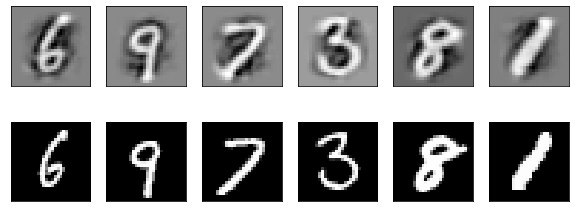

In [23]:
plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(3,6,i+1)
    k = np.random.randint(len(X))
    plt.imshow((np.sum((pca.components_*Xp[k].reshape(-1,1)), axis=0)).reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])
    plt.subplot(3,6,6+i+1)
    plt.imshow(X[k].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

### classification in the new representation space

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

print (np.mean(cross_val_score(GaussianNB(), X,y, cv=5 )))
print (np.mean(cross_val_score(GaussianNB(), Xp,y, cv=5 )))

0.5953333333333334
0.8320000000000001


### observe new representation of first image 

In [27]:
Xp[0]

array([-630.21531389,  730.97102721, -103.8003352 ,  -96.74972755,
       -147.33798951, -469.26160889, -411.86645654, -603.64390466,
        163.46361493, -244.0347    , -264.69119369,   -7.50383797,
        -93.3975134 , -315.31435269,  299.1809714 ,   43.28680394,
        -14.66232488,  373.48450521,  173.24335039,  -69.40894782,
         87.64575309, -271.77902368,   32.25135972,   -2.67182105,
        146.24528069, -194.55715413,   -6.74491957, -130.69711984,
        279.14771824,  -79.75214348,  -44.82952512,  112.91267319,
         23.96853185,  172.07553627,  113.1838189 , -136.8507872 ,
       -102.88617563,   14.84786566, -243.53909918,   85.88525801,
         53.46644658,   -5.90783116, -127.53066461,  161.68163898,
         57.63905722,  -48.02079529,   25.64113807,   45.20740761,
       -112.44241624,   20.97391373,  108.22843775,  -74.00116532,
        128.7009767 ,   13.92377096, -107.46924993,   10.64573186,
         66.48222612,   94.76587902,   39.62521978,   -8.64925

### pipelines

we must be careful when using these transformation in classification, as we should compute them (although in an unsupervised manner) only on train data

In [34]:
from sklearn.pipeline import Pipeline
pip = Pipeline([("PCA", PCA(n_components=60)), ("gaussian", GaussianNB())])
print (np.mean(cross_val_score(pip, X,y, cv=5 )))

0.8386666666666667


### how many components?

be careful with **model selection**, must partition train/val/test

In [32]:
from sklearn.model_selection import train_test_split
Xtv, Xts, ytv, yts = train_test_split(X,y, test_size=.3)

In [45]:
components_set = list(range(2,100,2))
scores = []
for n in components_set:
    print (n, end=" ")
    pip = Pipeline([("PCA", PCA(n_components=n)), ("gaussian", GaussianNB())])
    scores.append(np.mean(cross_val_score(pip, Xtv,ytv, cv=5 )))

2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 

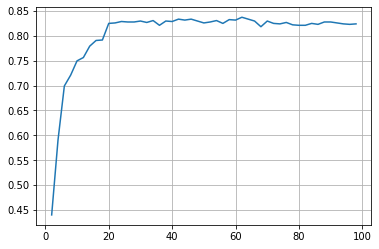

In [46]:
plt.plot(components_set, scores)
plt.grid();

In [48]:
best_n = components_set[np.argmax(scores)]
best_n

62

In [51]:
pip = Pipeline([("PCA", PCA(n_components=best_n)), ("gaussian", GaussianNB())])
pip.fit(Xtv,ytv)
print ("score of selected model %.3f"%pip.score(Xts, yts))

score of selected model 0.842


## Non negative matrix factorization

Descomponemos una matriz $V \in \mathbb{R}_+^{m\times n}$ en el producto $W \times H$, con $W \in \mathbb{R}_+^{m\times r}$ y $H \in \mathbb{R}_+^{r\times n}$ con la restricción de que todo sea positivo ($\in \mathbb{R}_+$), de forma que:

$$V \approx W \times H$$

Las filas de $H$ son los _componentes base_, y se soluciona planteándolo como un problema de optimización matemática con restricciones.

$$\begin{split}
argmin_{W,H}\;& ||V-W\times H||\\
s.t.&\;W,H \in \mathbb{R}_+
\end{split}$$

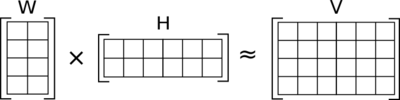

In [53]:
from IPython.display import Image
Image(filename='local/imgs/nmf.png')

### obtain decomponsition

In [54]:
from sklearn.decomposition import NMF
X=mnist[:,1:785]; y=mnist[:,0]

nmf = NMF(n_components=15, init="random")
Xn  = nmf.fit_transform(X)

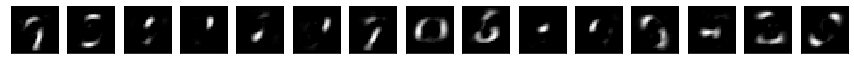

In [55]:
cols=20
plt.figure(figsize=(15,3))
for i in range(len(nmf.components_)):
    plt.subplot(len(nmf.components_)/15,15,i+1)
    plt.imshow(np.abs(nmf.components_[i].reshape(28,28)), cmap = plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

In [56]:
Xn[0,:]

array([0.        , 0.        , 0.74009474, 4.60742947, 5.83696664,
       0.        , 0.        , 0.        , 0.        , 5.51159421,
       0.        , 0.        , 0.46871235, 0.48231642, 6.38930657])

observe components are always positive

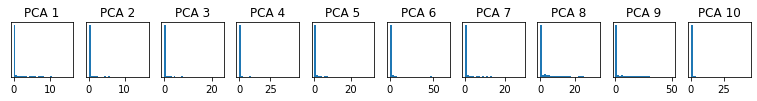

In [60]:
cols=20
plt.figure(figsize=(20,1))
for i in range(10):
    plt.subplot(1,15,i+1)
    plt.hist((nmf.components_[i]), bins=30)
    plt.yticks([])
    plt.title("PCA %d"%(i+1))

### check reconstruction

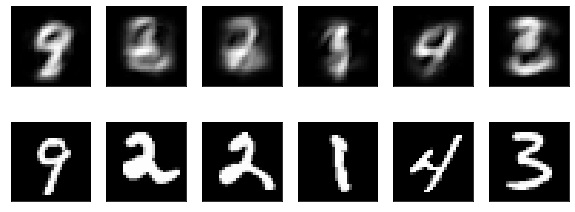

In [61]:
plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(3,6,i+1)
    k = np.random.randint(len(X))
    plt.imshow(np.abs(np.sum((nmf.components_*Xn[k].reshape(-1,1)), axis=0)).reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])
    plt.subplot(3,6,6+i+1)
    plt.imshow(X[k].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

### classification in the new representation space

In [62]:
print (np.mean(cross_val_score(GaussianNB(), X,y, cv=5 )))
print (np.mean(cross_val_score(GaussianNB(), Xn,y, cv=5 )))

0.5953333333333334
0.7699999999999999


### first image in new representation space
observe all components are positive

In [63]:
Xn[0]

array([0.        , 0.        , 0.74009474, 4.60742947, 5.83696664,
       0.        , 0.        , 0.        , 0.        , 5.51159421,
       0.        , 0.        , 0.46871235, 0.48231642, 6.38930657])

## NMF for face recognition

In [71]:
import pickle, gzip, numpy

with open('local/data/faces.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    faces = u.load()

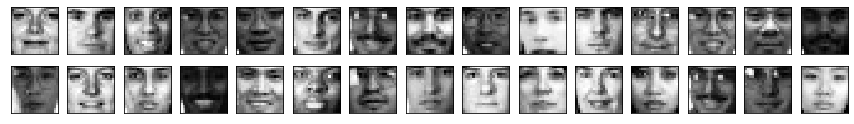

In [72]:
plt.figure(figsize=(15,2))
for i in range(30):
    plt.subplot(2,15,i+1)
    plt.imshow(faces[np.random.randint(len(faces))].reshape(19,19), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

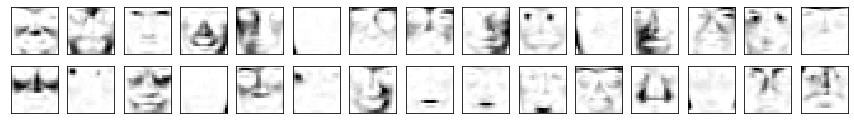

In [80]:
nmf      = NMF(n_components=30, init="random")
faces_n  = nmf.fit_transform(faces)
cols=20
plt.figure(figsize=(15,2))
for i in range(len(nmf.components_)):
    plt.subplot(np.ceil(len(nmf.components_)/15.),15,i+1)
    plt.imshow(np.abs(nmf.components_[i].reshape(19,19)), cmap = plt.cm.Greys)
    plt.xticks([]); plt.yticks([])

forcing sparseness in the components. extend the optimization problem with the $L_1$ norm on the base components:

$$\begin{split}
argmin_{W,H}\;& ||V-W\times H|| + ||H||^2_1\\
s.t.&\;W,H \in \mathbb{R}_+
\end{split}$$

we could also force sparness in the new representation
$$\begin{split}
argmin_{W,H}\;& ||V-W\times H|| + ||W||^2_1\\
s.t.&\;W,H \in \mathbb{R}_+
\end{split}$$


15246.686825590297


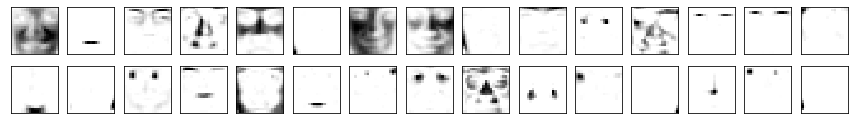

In [81]:
nmf      = NMF(n_components=30, init="random", alpha=1000, l1_ratio=1)
faces_n  = nmf.fit_transform(faces)
cols=20
plt.figure(figsize=(15,2))
print (np.sum(nmf.components_))
for i in range(len(nmf.components_)):
    plt.subplot(np.ceil(len(nmf.components_)/15.),15,i+1)
    plt.imshow(np.abs(nmf.components_[i].reshape(19,19)), cmap = plt.cm.Greys)
    plt.xticks([]); plt.yticks([])